## Import Library 

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Hugging Face를 통한 모델 및 토크나이저 Import
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup


## Load Data

In [53]:
df = pd.read_csv("preprocessed_title_test.csv", index_col = 0)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 913 entries, 0 to 975
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            913 non-null    object
 1   label            913 non-null    int64 
 2   processed_title  913 non-null    object
dtypes: int64(1), object(2)
memory usage: 28.5+ KB


In [55]:
df = df.dropna(subset=['processed_title'])

In [56]:
device = torch.device("cuda:0")

## Load Model

In [57]:
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Build Dataset

In [58]:
class KLUE_DATASET(Dataset):
    def __init__(self, dataset, tokenizer):
        
        self.dataset = dataset
        self.tokenizer = tokenizer
    
    def __len__(self):
        
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        sample = self.dataset.iloc[idx] 
        text = str(sample['processed_title'])
        label = int(sample['label'])

        # 토크나이징
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128, # 최대 길이 지정
            return_tensors="pt" # PyTorch 텐서 반환
        )

        # 하나의 sample의 정보를 dictionary로 구성
        return {
            'text': text,
            'input_ids': tokens['input_ids'].squeeze(0), # (batch_size=1, size)이므로 squeeze(0)으로 1인 차원 축소
            'token_type_ids': tokens['token_type_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'labels': label
        }

In [59]:
# test for KLUE dataset
test = KLUE_DATASET(df, tokenizer)
print(test[0])

{'text': '국제 교류 팀 계약직원 모집', 'input_ids': tensor([    2,  3854,  5459,  1823, 15900,  2252,  5287,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  

## DataLoader

In [60]:
from torch.utils.data import DataLoader, RandomSampler

test_dataset = KLUE_DATASET(df, tokenizer)
BATCH_SIZE = 8
test_dataloader = DataLoader(
    test_dataset, 
    sampler = RandomSampler(test_dataset),
    batch_size = BATCH_SIZE)

## Training Loop

In [61]:
def calcuate_accuracy(preds, labels):
    preds = np.argmax(preds, axis = 1)
    return np.sum(preds == labels) / len(labels)

In [62]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
num_epochs = 3

In [63]:
testing_info = []

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
model.load_state_dict(torch.load('../models/klue-bert-fine-tuned.pth'))
model.to(device)

for epoch in range(num_epochs):
    
    print(f"======Epoch {epoch+1} / {num_epochs}======")
    print("Test...")
    
    model.eval()
    
    total_test_accuracy = 0.0
    total_test_loss = 0.0
    
    for _, sample in enumerate(test_dataloader):
        
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        labels = sample['labels'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, 
                            token_type_ids = None,
                            attention_mask = attention_mask,
                            labels = labels)
            loss = outputs.loss
            total_test_loss += loss.item()
            
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()
            
            total_test_accuracy += calcuate_accuracy(logits, labels)
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)
    print(f"Validation Loss: {avg_test_loss:.4f}")
    print(f"Validation Accuracy: {avg_test_accuracy:.4f}")
    
    testing_info.append(
        {
            'epoch': epoch + 1,
            'test loss': avg_test_loss,
            'test accuracy': avg_test_accuracy
        }
    )
    print('\n')

print("Test Completed")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======Epoch 1 / 3======
Test...
Validation Loss: 0.3797
Validation Accuracy: 0.9217


======Epoch 2 / 3======
Test...
Validation Loss: 0.3797
Validation Accuracy: 0.9217


======Epoch 3 / 3======
Test...
Validation Loss: 0.3797
Validation Accuracy: 0.9217


Test Completed


## Visualization

In [64]:
df_train_info = pd.DataFrame(data = testing_info)
df_train_info = df_train_info.set_index('epoch')
df_train_info

,test loss,test accuracy
epoch,,
1,0.379663,0.921739
2,0.379663,0.921739
3,0.379666,0.921739


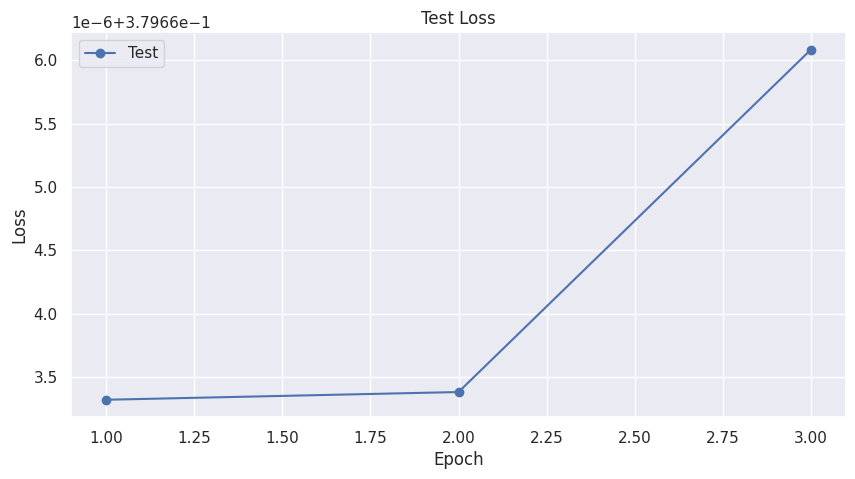

In [65]:
sns.set(style = 'darkgrid')
plt.figure(figsize = (10, 5))
plt.plot(df_train_info['test loss'], 'b-o', label = 'Test')

plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
final_test_accuracy = df_train_info['test accuracy'].mean()
print(f"final test accuracy: {final_test_accuracy:.4f}")

final test accuracy: 0.9217


In [67]:
from sklearn.metrics import f1_score

preds, gts = [], []

total_test_loss = 0.0

for _, sample in enumerate(test_dataloader):
    
    input_ids = sample['input_ids'].to(device)
    attention_mask = sample['attention_mask'].to(device)
    labels = sample['labels'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, 
                        token_type_ids = None,
                        attention_mask = attention_mask,
                        labels = labels)
        loss = outputs.loss
        total_test_loss += loss.item()
        
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
        gts.extend(labels)
        pred = np.argmax(logits, axis = 1)
        preds.extend(pred)

# F1 score 계산
final_f1 = f1_score(gts, preds)
print(f"Test Data F1 Score: {final_f1}")

Test Data F1 Score: 0.9032258064516129


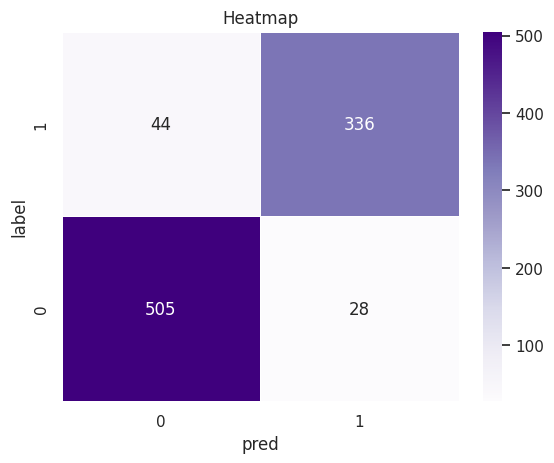

In [68]:
test_df = pd.DataFrame({'pred': preds, 'label': gts})
test_df

confusion_matrix = pd.crosstab(test_df['label'], test_df['pred'])
confusion_matrix.index = test_df['pred'].unique()
confusion_matrix.columns = test_df['label'].unique()
confusion_matrix = confusion_matrix.iloc[::-1, :]

sns.heatmap(confusion_matrix, cmap = 'Purples', annot = True, linewidth = .5, fmt = ".0f")
plt.title("Heatmap")
plt.ylabel("label")
plt.xlabel("pred")
plt.show()